# Exploratory Analysis and Model Calibration
The purpose of this notebook is to use two different datasets to determine an efficient and fast method for the convergence of a given gradient in order to apply this method to a real dataset. For this purpose the two datasets under analysis are the following:
- An artificially generated synthetic dataset
- A toy dataset taken from the Seaborn library examples

In [1]:
# Manipulation / processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Toy dataset loading
import seaborn as sns

# Local modules
from make_data import make_data # For making synthetic datasets
import optimizer as opt # For loading optimization functions and other utilities

## Synthetic dataset analysis
In this section the synthetic dataset is build and a specific percentage of labels is hidden for building the semi-supervised problem. Finally the weights are extracted.

In [2]:
# Semi-supervised problem building

n_samples = 1500 # Number of points to be generated
labeled_perc = 0.15 # Percentage of labeled points

n_labeled = int(labeled_perc * n_samples) # Number of labeled points
n_unlabeled = n_samples - n_labeled # Number of unlabeled points

random_state = 16

print("Total number of points (2D): {}".format(n_samples))
print("Number of labeled points: {} ({} %)".format(n_labeled, 100 * labeled_perc))
print("Number of unlabeled points: {} ({} %)".format(n_unlabeled, 100 * (1 - labeled_perc)))

Total number of points (2D): 1500
Number of labeled points: 225 (15.0 %)
Number of unlabeled points: 1275 (85.0 %)


In [3]:
# Points and labels subdivision
points, labels = make_data(n_samples = n_samples, type = "circles", random_state = random_state)

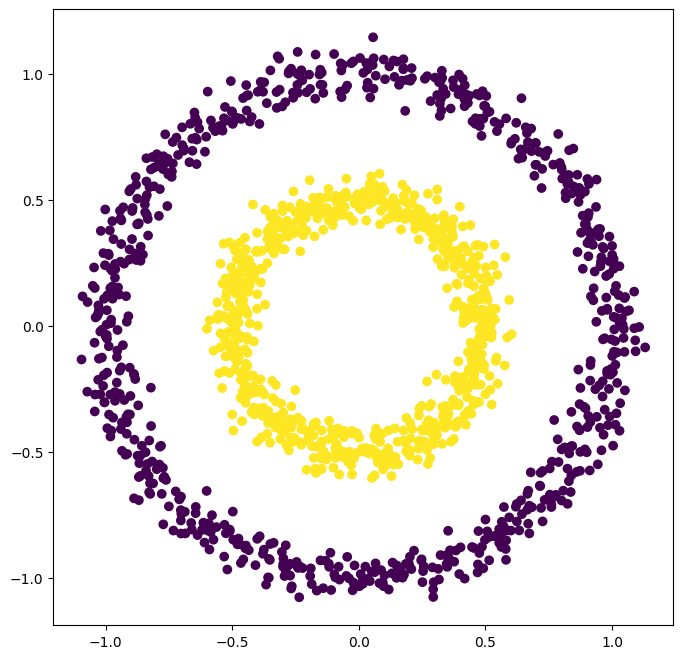

In [4]:
# Visualizing the dataset (Different colors for different classes)
plt.figure(figsize = (8, 8))
plt.scatter(np.array(points)[:, 0], np.array(points)[:, 1], c = (labels))
plt.show()

In [5]:
# Extract labeled and unlabeled indices
labeled_indices = np.random.choice(n_samples, n_labeled, replace = False)
unlabeled_indices = np.setdiff1d(np.arange(n_samples), labeled_indices)

# Extract labeled and unlabeled data
points_labeled = points[labeled_indices]
points_unlabeled = points[unlabeled_indices]

y_labeled = labels[labeled_indices]
y_unlabeled = labels[unlabeled_indices]

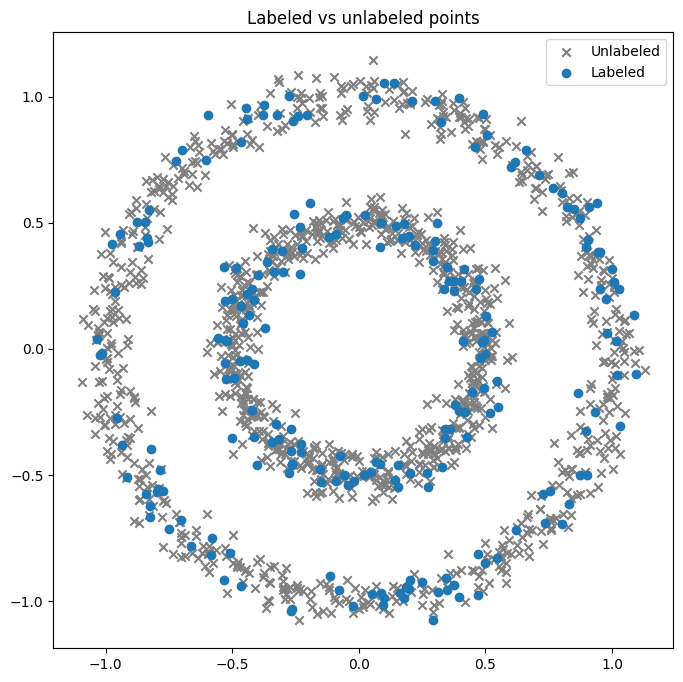

In [6]:
# Visualizing the dataset (In blue the points for which the label has not been hidden)
plt.figure(figsize = (8, 8))
plt.scatter(np.array(points_unlabeled)[:, 0], np.array(points_unlabeled)[:, 1], c = 'gray', marker='x')
plt.scatter(np.array(points_labeled)[:, 0], np.array(points_labeled)[:, 1], marker = 'o')
plt.title("Labeled vs unlabeled points")
plt.legend(["Unlabeled", "Labeled"])
plt.show()

In this steps the dataset is normalized and, using a similarity measure (a kernel RBF with a gamma to be specified as an input attribute), features weights are calculated.

In [7]:
# Weights calculation (normalization, euclidian distance and similarity RBF kernel measure)
gamma = 3

weights_labeled_unlabeled, weights_unlabeled_unlabeled = opt.weights_extraction(points_unlabeled, points_labeled, gamma)

### Hessian matrix and Lipschitz constant calculation
In this section the Hessian matrix has been calculated for extracting the Lipschitz constant from the eigenvalues of the matrix, in order to get an important reference for finding a proper learning rate to use in the gradient descent task. For this part a regularization term has been introduced for keeping stable the calculation and getting in this way coherent values of the Lipschitz constant through several runs of the code. A condition number has been used as a measure of stability for the Hessian matrix and, thus, as a tool for deciding a proper value for the regularization term.

The Hessian matrix has the following form:

$$
H_{j \mathrm{k}}=\nabla_{y^(j) y^{(k)}}^2 f(\boldsymbol{y})=\left\{\begin{array}{l}
2\left(\sum_{i=1}^l w_{i j}+\sum_{i=1}^u \bar{w}_{i j}-\bar{w}_{i j}\right) \text { if } h=k \\
-2 \bar{w}_{j k} \text { if } j \neq k
\end{array}\right.
$$

In [8]:
alpha = 0.01

H = opt.hessian_matrix(weights_labeled_unlabeled, weights_unlabeled_unlabeled, n_unlabeled, alpha)
L = opt.lipschitz_constant(H)
max_alpha = 1/L

print("Lipschitz constant value: {}".format(max_alpha))
print("Hessian condition number: {}".format(np.linalg.cond(H)))

Lipschitz constant value: 0.003267296213664576
Hessian condition number: 10.216299274062665


### Simple gradient descent
A simple gradient descent is performed in this section, using a grid search approach for studying the behaviour of the gradient for values of the learning rates in a neighborhood of 1/L. The ultimamte goal is to develop a succesful method which can be used to study a real dataset problem.

The considered loss function is:

$$
f(\mathbf{y}) = \sum_{i=1}^l\sum_{j=1}^u w_{ij}(y^{(j)} -\bar{y}^{(i)})^2 + \frac{1}{2} \sum_{i=1}^u\sum_{j=1}^u \bar{w}_{ij}(y^{(i)} -y^{(j)})^2
$$

Thus, the following must be found::

$$
\min_{\mathbf{y} \in \mathbb{R}^u} f(\mathbf{y})
$$

For finding this minimum, the following gradient is considered (the formula shows the gradient for a single variable):

$$
\nabla_{y^{(j)}}f(\mathbf{y}) = 2 \sum_{i=1}^lw_{ij}(y^{(j)} - \bar{y}^{(i)}) + 2 \sum_{i=1}^u\bar{w}_{ij}(y^{(j)} - y^{(i)})
$$

Where:
- $l$ and $u$ refers to labeled and unlabeled data, respectively
- $w$ is the weights matrix calculated between labeled and unlabeled examples
- $\bar{w}$ is the weights matrix calculated between unlabeled and unlabeled examples
- $\mathbf{y}$ is the vector of unlabeled exampled that must be found
- $\bar{\mathbf{y}}$ is the target vector of labeled examples

In [9]:
# The vector to be optimized is initialized randomly
classes = np.unique(labels)

np.random.seed(16)
y_unlabeled_init = np.random.choice(classes, size = n_unlabeled)

# Final results
final_results = {"synthetic" : dict(), "toy" : dict()}

In [10]:
# Iterations
num_iter = 50

# Tested learning rates (they must be greater than 0 and include 1/L)
values_to_test = 15
learning_rates = np.linspace(0, 3 * max_alpha, num = values_to_test)
learning_rates = np.append(1/L, learning_rates)
learning_rates = np.sort(learning_rates)

c = 1
results = dict()

for learning_rate in learning_rates:
  print("Testing learning rate: {} ({} / {})".format(learning_rate, c, len(learning_rates)))
  y_unlabeled_optimized, losses, tot_time, accuracies = opt.gradient_descent(
    weights_labeled_unlabeled,
    weights_unlabeled_unlabeled,
    y_unlabeled_init,
    y_unlabeled,
    y_labeled,
    n_labeled,
    n_unlabeled,
    num_iter,
    learning_rate,
    verbose = False
    )

  # Results are added to a dictionary
  results[learning_rate] = {
    'y_unlabeled_optimized': y_unlabeled_optimized,
    'losses': losses,
    'tot_times': tot_time,
    'accuracies' : accuracies
  }
  c += 1

Testing learning rate: 0.0 (1 / 16)
Testing learning rate: 0.0007001349029281235 (2 / 16)
Testing learning rate: 0.001400269805856247 (3 / 16)
Testing learning rate: 0.0021004047087843703 (4 / 16)
Testing learning rate: 0.002800539611712494 (5 / 16)
Testing learning rate: 0.003267296213664576 (6 / 16)
Testing learning rate: 0.0035006745146406175 (7 / 16)
Testing learning rate: 0.004200809417568741 (8 / 16)
Testing learning rate: 0.004900944320496864 (9 / 16)
Testing learning rate: 0.005601079223424988 (10 / 16)
Testing learning rate: 0.006301214126353111 (11 / 16)
Testing learning rate: 0.007001349029281235 (12 / 16)
Testing learning rate: 0.007701483932209359 (13 / 16)
Testing learning rate: 0.008401618835137481 (14 / 16)
Testing learning rate: 0.009101753738065606 (15 / 16)
Testing learning rate: 0.009801888640993729 (16 / 16)


In [11]:
# Extracting relevant data from the results dictionary
final_accuracies = pd.DataFrame([(lr, results[lr]['accuracies'][-1]) for lr in results.keys()], columns = ["learning_rates", "final_accuracies"])

best_learning_rate = final_accuracies.sort_values(by = 'final_accuracies', ascending = False).iloc[0, 0]
best_accuracy = round(final_accuracies.sort_values(by = 'final_accuracies', ascending = False).iloc[0, 1], 4)

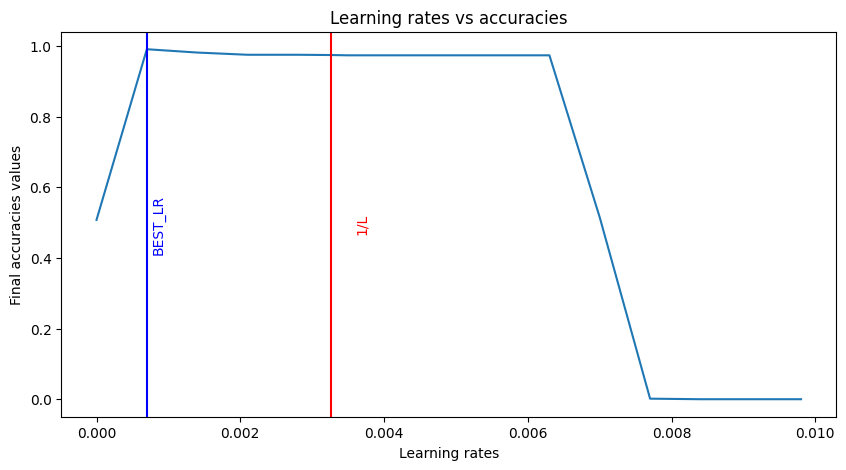

In [12]:
# Final plot for showing the accuracy trend for different learning rates

plt.figure(figsize = (10, 5))
plt.plot(final_accuracies["learning_rates"], final_accuracies["final_accuracies"])

# Line to show the position of 1/L
LC_x = max_alpha * 1.1
LC_y = (final_accuracies["final_accuracies"].max() + final_accuracies["final_accuracies"].min()) / 2
plt.axvline(x=max_alpha, color = 'r')
plt.text(LC_x, LC_y, '1/L', rotation=90, verticalalignment='center', color='red')

# Line to show the position of the best learning rate found by the search performed
BLR_x = best_learning_rate * 1.1
BLR_y = LC_y
plt.axvline(x=best_learning_rate, color = 'b')
plt.text(best_learning_rate * 1.1, (final_accuracies["final_accuracies"].max() + final_accuracies["final_accuracies"].min()) / 2, 'BEST_LR', rotation=90, verticalalignment='center', color='blue')

plt.xlabel("Learning rates")
plt.ylabel("Final accuracies values")
plt.title("Learning rates vs accuracies")
plt.show()

In [13]:
# Best results printing
print("Best results\n")
print("Best accuracy: {}".format(best_accuracy))
print("Best learning rate: {}".format(best_learning_rate))

final_results["synthetic"]["GD"] = {"Best accuracy" : best_accuracy, "1/L accuracy" : results[1/L]['accuracies'][-1]}

Best results

Best accuracy: 0.9906
Best learning rate: 0.0007001349029281235


### Block coordinate gradient descent
In this section a Block Coordiante Gradient descent is used, with two methods for selecting blocks:
- Gauss_Southwell method
- Random permutation method

The approach is the same used for gradient descent, i.e., a grid search-like structure for having a look at the neighborhood of 1/L

In [14]:
# The vector to be optimized is initialized randomly
n_unlabeled = len(y_unlabeled)
classes = [0, 1]

np.random.seed(16)
y_unlabeled_init = np.random.choice(classes, size = n_unlabeled)
y_unlabeled_init = y_unlabeled_init.astype(np.float64)

#### Random permutation method

In [15]:
# Iterations
num_iter = 50

# Tested learning rates (they must be greater than 0 and include 1/L)
values_to_test = 20
learning_rates = np.linspace(0, 15 * max_alpha, num = values_to_test)
learning_rates = np.append(1/L, learning_rates) 
learning_rates = np.sort(learning_rates)

block_size = 1

# Method used for block selection
method = "random_permutation"

c = 1
results = dict()

for learning_rate in learning_rates:
  y_unlabeled_init_copy = y_unlabeled_init.copy()
  print("Testing learning rate: {} ({} / {})".format(learning_rate, c, len(learning_rates)))
  y_unlabeled_optimized, losses, tot_time, accuracies = opt.block_coordinate_gradient_descent(
      weights_labeled_unlabeled,
      weights_unlabeled_unlabeled,
      y_unlabeled_init_copy,
      y_labeled,
      y_unlabeled,
      n_labeled,
      n_unlabeled,
      num_iter,
      learning_rate,
      block_size,
      method = method,
      verbose = False
      )

  # Results are added to a dictionary
  results[learning_rate] = {
    'y_unlabeled_optimized': y_unlabeled_optimized,
    'losses': losses,
    'tot_times': tot_time,
    'accuracies' : accuracies
  }
  c += 1

Testing learning rate: 0.0 (1 / 21)
Testing learning rate: 0.002579444379208876 (2 / 21)
Testing learning rate: 0.003267296213664576 (3 / 21)
Testing learning rate: 0.005158888758417752 (4 / 21)
Testing learning rate: 0.007738333137626627 (5 / 21)
Testing learning rate: 0.010317777516835503 (6 / 21)
Testing learning rate: 0.01289722189604438 (7 / 21)
Testing learning rate: 0.015476666275253254 (8 / 21)
Testing learning rate: 0.01805611065446213 (9 / 21)
Testing learning rate: 0.020635555033671007 (10 / 21)
Testing learning rate: 0.023214999412879883 (11 / 21)
Testing learning rate: 0.02579444379208876 (12 / 21)
Testing learning rate: 0.028373888171297636 (13 / 21)
Testing learning rate: 0.03095333255050651 (14 / 21)
Testing learning rate: 0.03353277692971539 (15 / 21)
Testing learning rate: 0.03611222130892426 (16 / 21)
Testing learning rate: 0.03869166568813314 (17 / 21)
Testing learning rate: 0.041271110067342014 (18 / 21)
Testing learning rate: 0.043850554446550886 (19 / 21)
Testing

In [16]:
# Extracting relevant data from the results dictionary
final_accuracies = pd.DataFrame([(lr, results[lr]['accuracies'][-1]) for lr in results.keys()], columns = ["learning_rates", "final_accuracies"])

best_learning_rate = final_accuracies.sort_values(by = 'final_accuracies', ascending = False).iloc[0, 0]
best_accuracy = round(final_accuracies.sort_values(by = 'final_accuracies', ascending = False).iloc[0, 1], 4)

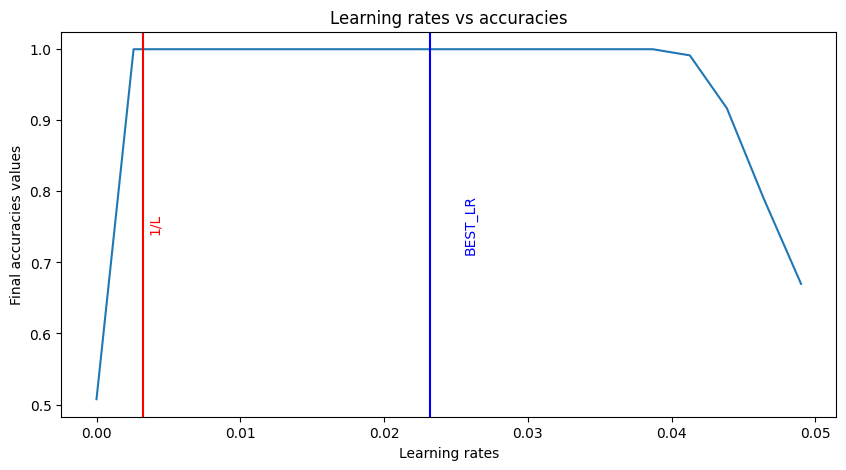

In [17]:
# Final plot for showing the accuracy trend for different learning rates

plt.figure(figsize = (10, 5))
plt.plot(final_accuracies["learning_rates"], final_accuracies["final_accuracies"])

# Line to show the position of 1/L
LC_x = max_alpha * 1.1
LC_y = (final_accuracies["final_accuracies"].max() + final_accuracies["final_accuracies"].min()) / 2
plt.axvline(x=max_alpha, color = 'r')
plt.text(LC_x, LC_y, '1/L', rotation=90, verticalalignment='center', color='red')

# Line to show the position of the best learning rate found by the search performed
BLR_x = best_learning_rate * 1.1
BLR_y = LC_y
plt.axvline(x=best_learning_rate, color = 'b')
plt.text(best_learning_rate * 1.1, (final_accuracies["final_accuracies"].max() + final_accuracies["final_accuracies"].min()) / 2, 'BEST_LR', rotation=90, verticalalignment='center', color='blue')

plt.xlabel("Learning rates")
plt.ylabel("Final accuracies values")
plt.title("Learning rates vs accuracies")
plt.show()

In [18]:
# Best results printing
print("Best results\n")
print("Best accuracy: {}".format(best_accuracy))
print("Best learning rate: {}".format(best_learning_rate))

final_results["synthetic"]["RP-BCGD"] = {"Best accuracy" : best_accuracy, "1/L accuracy" : results[1/L]['accuracies'][-1]}

Best results

Best accuracy: 1.0
Best learning rate: 0.023214999412879883


#### Gauss-Southwell method

In [19]:
# Iterations
num_iter = 500

# Tested learning rates (they must be greater than 0 and include 1/L)
values_to_test = 20
learning_rates = np.linspace(0, 15 * max_alpha, num = values_to_test)
learning_rates = np.append(1/L, learning_rates)
learning_rates = np.sort(learning_rates)

block_size = 1

# Method used for block selection
method = "gauss_southwell"

c = 1
results = dict()

for learning_rate in learning_rates:
  y_unlabeled_init_copy = y_unlabeled_init.copy()
  print("Testing learning rate: {} ({} / {})".format(learning_rate, c, len(learning_rates)))
  y_unlabeled_optimized, losses, tot_time, accuracies = opt.block_coordinate_gradient_descent(
      weights_labeled_unlabeled,
      weights_unlabeled_unlabeled,
      y_unlabeled_init_copy,
      y_labeled,
      y_unlabeled,
      n_labeled,
      n_unlabeled,
      num_iter,
      learning_rate,
      block_size,
      method = method,
      verbose = False
      )

  # Results are added to a dictionary
  results[learning_rate] = {
    'y_unlabeled_optimized': y_unlabeled_optimized,
    'losses': losses,
    'tot_times': tot_time,
    'accuracies' : accuracies
  }
  c += 1

Testing learning rate: 0.0 (1 / 21)
Testing learning rate: 0.002579444379208876 (2 / 21)
Testing learning rate: 0.003267296213664576 (3 / 21)
Testing learning rate: 0.005158888758417752 (4 / 21)
Testing learning rate: 0.007738333137626627 (5 / 21)
Testing learning rate: 0.010317777516835503 (6 / 21)
Testing learning rate: 0.01289722189604438 (7 / 21)
Testing learning rate: 0.015476666275253254 (8 / 21)
Testing learning rate: 0.01805611065446213 (9 / 21)
Testing learning rate: 0.020635555033671007 (10 / 21)
Testing learning rate: 0.023214999412879883 (11 / 21)
Testing learning rate: 0.02579444379208876 (12 / 21)
Testing learning rate: 0.028373888171297636 (13 / 21)
Testing learning rate: 0.03095333255050651 (14 / 21)
Testing learning rate: 0.03353277692971539 (15 / 21)
Testing learning rate: 0.03611222130892426 (16 / 21)
Testing learning rate: 0.03869166568813314 (17 / 21)
Testing learning rate: 0.041271110067342014 (18 / 21)
Testing learning rate: 0.043850554446550886 (19 / 21)
Testing

In [20]:
# Extracting relevant data from the results dictionary
final_accuracies = pd.DataFrame([(lr, results[lr]['accuracies'][-1]) for lr in results.keys()], columns = ["learning_rates", "final_accuracies"])

best_learning_rate = final_accuracies.sort_values(by = 'final_accuracies', ascending = False).iloc[0, 0]
best_accuracy = round(final_accuracies.sort_values(by = 'final_accuracies', ascending = False).iloc[0, 1], 4)

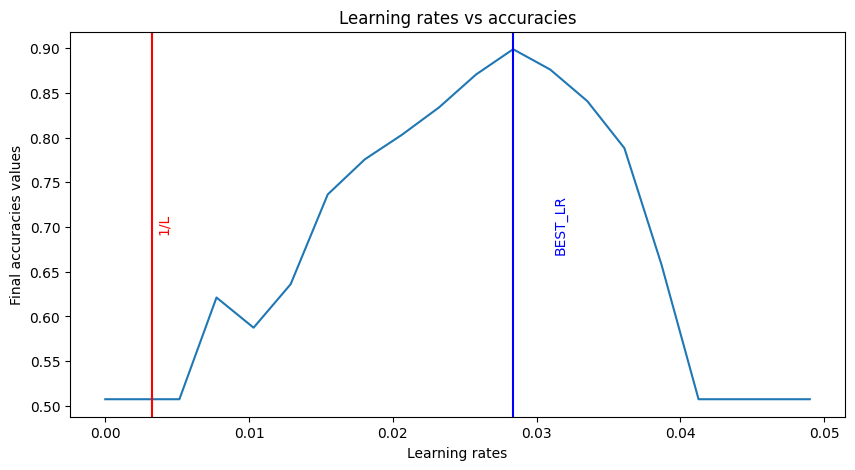

In [21]:
# Final plot for showing the accuracy trend for different learning rates

plt.figure(figsize = (10, 5))
plt.plot(final_accuracies["learning_rates"], final_accuracies["final_accuracies"])

# Line to show the position of 1/L
LC_x = max_alpha * 1.1
LC_y = (final_accuracies["final_accuracies"].max() + final_accuracies["final_accuracies"].min()) / 2
plt.axvline(x=max_alpha, color = 'r')
plt.text(LC_x, LC_y, '1/L', rotation=90, verticalalignment='center', color='red')

# Line to show the position of the best learning rate found by the search performed
BLR_x = best_learning_rate * 1.1
BLR_y = LC_y
plt.axvline(x=best_learning_rate, color = 'b')
plt.text(best_learning_rate * 1.1, (final_accuracies["final_accuracies"].max() + final_accuracies["final_accuracies"].min()) / 2, 'BEST_LR', rotation=90, verticalalignment='center', color='blue')

plt.xlabel("Learning rates")
plt.ylabel("Final accuracies values")
plt.title("Learning rates vs accuracies")
plt.show()

In [22]:
# Best results printing
print("Best results\n")
print("Best accuracy: {}".format(best_accuracy))
print("Best learning rate: {}".format(best_learning_rate))

final_results["synthetic"]["GS-BCGD"] = {"Best accuracy" : best_accuracy, "1/L accuracy" : results[1/L]['accuracies'][-1]}

Best results

Best accuracy: 0.8988
Best learning rate: 0.028373888171297636


## Penguins dataset from Seaborn
In this section the Penguins toy dataset from Seaborn examples has been used, hiding again a specific percentage of labels for building the semi-supervised problem and finally extracting the weights

In [23]:
# Dataset loading and conversion to a Pandas dataframe
penguins_df = pd.DataFrame(sns.load_dataset('penguins'))

In [24]:
# The dataset shows "NaN" values and string-type categorical features. Some processing is needed before building the problem
penguins_df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [25]:
# Null values discarding
penguins_df.dropna(inplace = True)

# Categorical string features onversion to numerical categories (using the factorize method of Pandas)
for column in penguins_df.columns:
  if pd.api.types.is_string_dtype(penguins_df[column]):
    penguins_df[column] = pd.factorize(penguins_df[column])[0]

penguins_df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,0,39.1,18.7,181.0,3750.0,0
1,0,0,39.5,17.4,186.0,3800.0,1
2,0,0,40.3,18.0,195.0,3250.0,1
4,0,0,36.7,19.3,193.0,3450.0,1
5,0,0,39.3,20.6,190.0,3650.0,0


In [26]:
n_samples = penguins_df.shape[0] # Number of points to be generated
labeled_perc = 0.10 # Percentage of labeled points

n_labeled = int(labeled_perc * n_samples) # Number of labeled points
n_unlabeled = n_samples - n_labeled # Number of unlabeled points

random_state = 16

print("Total number of points (2D): {}".format(n_samples))
print("Number of labeled points: {} ({} %)".format(n_labeled, 100 * labeled_perc))
print("Number of unlabeled points: {} ({} %)".format(n_unlabeled, 100 * (1 - labeled_perc)))

Total number of points (2D): 333
Number of labeled points: 33 (10.0 %)
Number of unlabeled points: 300 (90.0 %)


In [27]:
# Assign points and labels
points = np.array(penguins_df.drop('sex', axis = 1))
labels = np.array(penguins_df['sex'])

# Extract labeled and unlabeled indices
labeled_indices = np.random.choice(n_samples, n_labeled, replace = False)
unlabeled_indices = np.setdiff1d(np.arange(n_samples), labeled_indices)

# Extract labeled and unlabeled data
points_labeled = points[labeled_indices]
points_unlabeled = points[unlabeled_indices]

y_labeled = labels[labeled_indices]
y_unlabeled = labels[unlabeled_indices]

In [28]:
# Weights calculation (normalization, euclidian distance and similarity RBF kernel measure)
gamma = 5

weights_labeled_unlabeled, weights_unlabeled_unlabeled = opt.weights_extraction(points_unlabeled, points_labeled, gamma)

### Hessian matrix and Lipschitz constant calculation

In [29]:
alpha = 2.5
H = opt.hessian_matrix(weights_labeled_unlabeled, weights_unlabeled_unlabeled, n_unlabeled, alpha)
L = opt.lipschitz_constant(H)
max_alpha = 1/L

print("Lipschitz constant value: {}".format(max_alpha))
print("Condition number: {}".format(np.linalg.cond(H)))

Lipschitz constant value: 0.03462275142904276
Condition number: 11.55282041951055


### Simple gradient descent

In [30]:
classes = np.unique(labels)

np.random.seed(16)
y_unlabeled_init = np.random.choice(classes, size = n_unlabeled)

In [31]:
# Iterations
num_iter = 500

# Tested learning rates (they must be greater than 0 and include 1/L)
values_to_test = 15
learning_rates = np.linspace(0, 3 * max_alpha, num = values_to_test - 1)
learning_rates = np.append(1/L, learning_rates)
learning_rates = np.sort(learning_rates)

c = 1
results = dict()

for learning_rate in learning_rates:
  print("Testing learning rate: {} ({} / {})".format(learning_rate, c, len(learning_rates)))
  y_unlabeled_optimized, losses, tot_time, accuracies = opt.gradient_descent(
      weights_labeled_unlabeled,
      weights_unlabeled_unlabeled,
      y_unlabeled_init,
      y_unlabeled,
      y_labeled,
      n_labeled,
      n_unlabeled,
      num_iter,
      learning_rate,
      verbose = False
      )

  # Results are added to a dictionary
  results[learning_rate] = {
    'y_unlabeled_optimized': y_unlabeled_optimized,
    'losses': losses,
    'tot_times': tot_time,
    'accuracies' : accuracies
  }
  c += 1

Testing learning rate: 0.0 (1 / 15)
Testing learning rate: 0.007989865714394483 (2 / 15)
Testing learning rate: 0.015979731428788967 (3 / 15)
Testing learning rate: 0.02396959714318345 (4 / 15)
Testing learning rate: 0.03195946285757793 (5 / 15)
Testing learning rate: 0.03462275142904276 (6 / 15)
Testing learning rate: 0.03994932857197242 (7 / 15)
Testing learning rate: 0.0479391942863669 (8 / 15)
Testing learning rate: 0.05592906000076138 (9 / 15)
Testing learning rate: 0.06391892571515587 (10 / 15)
Testing learning rate: 0.07190879142955035 (11 / 15)
Testing learning rate: 0.07989865714394484 (12 / 15)
Testing learning rate: 0.08788852285833931 (13 / 15)
Testing learning rate: 0.0958783885727338 (14 / 15)
Testing learning rate: 0.10386825428712829 (15 / 15)


In [32]:
# Extracting relevant data from the results dictionary
final_accuracies = pd.DataFrame([(lr, results[lr]['accuracies'][-1]) for lr in results.keys()], columns = ["learning_rates", "final_accuracies"])

best_learning_rate = final_accuracies.sort_values(by = 'final_accuracies', ascending = False).iloc[0, 0]
best_accuracy = round(final_accuracies.sort_values(by = 'final_accuracies', ascending = False).iloc[0, 1], 4)

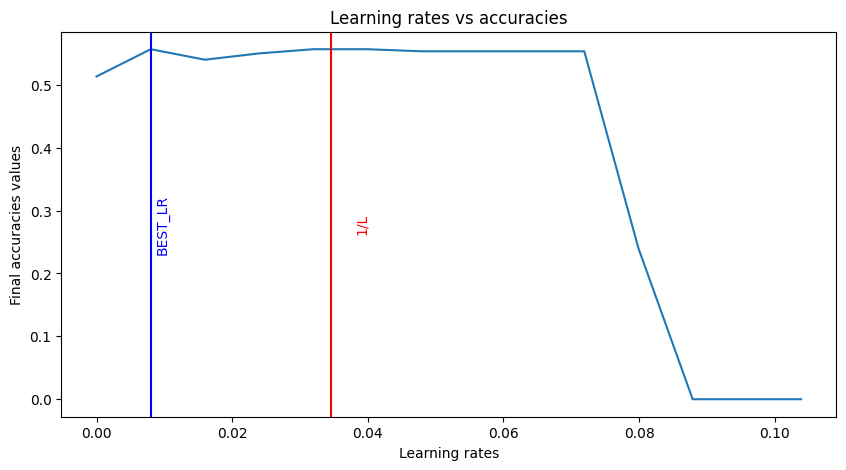

In [33]:
# Final plot for showing the accuracy trend for different learning rates

plt.figure(figsize = (10, 5))
plt.plot(final_accuracies["learning_rates"], final_accuracies["final_accuracies"])

# Line to show the position of 1/L
LC_x = max_alpha * 1.1
LC_y = (final_accuracies["final_accuracies"].max() + final_accuracies["final_accuracies"].min()) / 2
plt.axvline(x=max_alpha, color = 'r')
plt.text(LC_x, LC_y, '1/L', rotation=90, verticalalignment='center', color='red')

# Line to show the position of the best learning rate found by the search performed
BLR_x = best_learning_rate * 1.1
BLR_y = LC_y
plt.axvline(x=best_learning_rate, color = 'b')
plt.text(best_learning_rate * 1.1, (final_accuracies["final_accuracies"].max() + final_accuracies["final_accuracies"].min()) / 2, 'BEST_LR', rotation=90, verticalalignment='center', color='blue')

plt.xlabel("Learning rates")
plt.ylabel("Final accuracies values")
plt.title("Learning rates vs accuracies")
plt.show()

In [34]:
# Best results printing
print("Best results\n")
print("Best accuracy: {}".format(best_accuracy))
print("Best learning rate: {}".format(best_learning_rate))

final_results["toy"]["GD"] = {"Best accuracy" : best_accuracy, "1/L accuracy" : results[1/L]['accuracies'][-1]}

Best results

Best accuracy: 0.5567
Best learning rate: 0.007989865714394483


### Block coordinate gradient descent
A BCGD is performed in this section, using two methods for selecting the blocks:
- Randomized method
- Gauss-Southwell method

In [35]:
classes = np.unique(labels)

np.random.seed(16)
y_unlabeled_init = np.random.choice(classes, size = n_unlabeled)
y_unlabeled_init = y_unlabeled_init.astype(np.float64)

#### Random permutation method

In [36]:
# Iterations
num_iter = 250

# Tested learning rates (they must be greater than 0 and include 1/L)
values_to_test = 20
learning_rates = np.linspace(0, 30 * max_alpha, num = values_to_test - 1)
learning_rates = np.append(1/L, learning_rates)
learning_rates = np.sort(learning_rates)

block_size = 1

# Method used for block selection
method = "random_permutation"

c = 1
results = dict()

for learning_rate in learning_rates:
  y_unlabeled_init_copy = y_unlabeled_init.copy()
  print("Testing learning rate: {} ({} / {})".format(learning_rate, c, len(learning_rates)))
  y_unlabeled_optimized, losses, tot_time, accuracies = opt.block_coordinate_gradient_descent(
      weights_labeled_unlabeled,
      weights_unlabeled_unlabeled,
      y_unlabeled_init_copy,
      y_labeled,
      y_unlabeled,
      n_labeled,
      n_unlabeled,
      num_iter,
      learning_rate,
      block_size,
      method = method,
      verbose = False
      )

  # Results are added to a dictionary
  results[learning_rate] = {
    'y_unlabeled_optimized': y_unlabeled_optimized,
    'losses': losses,
    'tot_times': tot_time,
    'accuracies' : accuracies
  }
  c += 1

Testing learning rate: 0.0 (1 / 20)
Testing learning rate: 0.03462275142904276 (2 / 20)
Testing learning rate: 0.05770458571507126 (3 / 20)
Testing learning rate: 0.11540917143014252 (4 / 20)
Testing learning rate: 0.1731137571452138 (5 / 20)
Testing learning rate: 0.23081834286028505 (6 / 20)
Testing learning rate: 0.28852292857535633 (7 / 20)
Testing learning rate: 0.3462275142904276 (8 / 20)
Testing learning rate: 0.40393210000549884 (9 / 20)
Testing learning rate: 0.4616366857205701 (10 / 20)
Testing learning rate: 0.5193412714356413 (11 / 20)
Testing learning rate: 0.5770458571507127 (12 / 20)
Testing learning rate: 0.6347504428657839 (13 / 20)
Testing learning rate: 0.6924550285808552 (14 / 20)
Testing learning rate: 0.7501596142959264 (15 / 20)
Testing learning rate: 0.8078642000109977 (16 / 20)
Testing learning rate: 0.8655687857260689 (17 / 20)
Testing learning rate: 0.9232733714411402 (18 / 20)
Testing learning rate: 0.9809779571562115 (19 / 20)
Testing learning rate: 1.03868

In [37]:
# Extracting relevant data from the results dictionary
final_accuracies = pd.DataFrame([(lr, results[lr]['accuracies'][-1]) for lr in results.keys()], columns = ["learning_rates", "final_accuracies"])

best_learning_rate = final_accuracies.sort_values(by = 'final_accuracies', ascending = False).iloc[0, 0]
best_accuracy = round(final_accuracies.sort_values(by = 'final_accuracies', ascending = False).iloc[0, 1], 4)

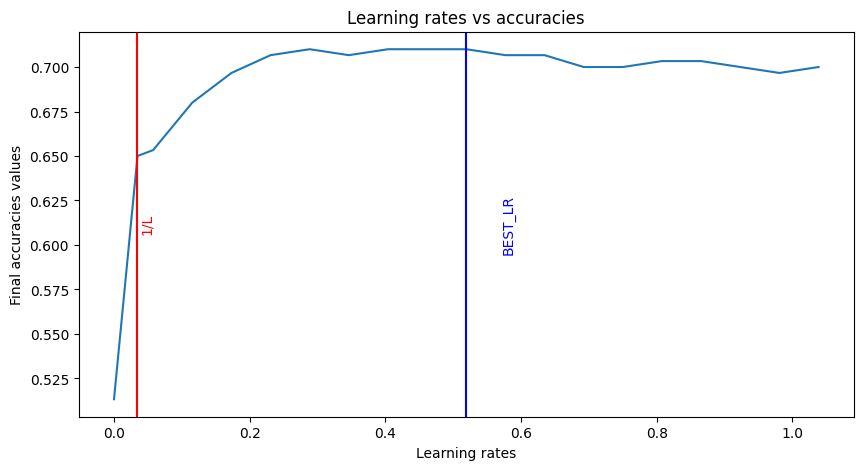

In [38]:
# Final plot for showing the accuracy trend for different learning rates

plt.figure(figsize = (10, 5))
plt.plot(final_accuracies["learning_rates"], final_accuracies["final_accuracies"])

# Line to show the position of 1/L
LC_x = max_alpha * 1.1
LC_y = (final_accuracies["final_accuracies"].max() + final_accuracies["final_accuracies"].min()) / 2
plt.axvline(x=max_alpha, color = 'r')
plt.text(LC_x, LC_y, '1/L', rotation=90, verticalalignment='center', color='red')

# Line to show the position of the best learning rate found by the search performed
BLR_x = best_learning_rate * 1.1
BLR_y = LC_y
plt.axvline(x=best_learning_rate, color = 'b')
plt.text(best_learning_rate * 1.1, (final_accuracies["final_accuracies"].max() + final_accuracies["final_accuracies"].min()) / 2, 'BEST_LR', rotation=90, verticalalignment='center', color='blue')

plt.xlabel("Learning rates")
plt.ylabel("Final accuracies values")
plt.title("Learning rates vs accuracies")
plt.show()

In [39]:
# Best results printing
print("Best results\n")
print("Best accuracy: {}".format(best_accuracy))
print("Best learning rate: {}".format(best_learning_rate))

final_results["toy"]["RP-BCGD"] = {"Best accuracy" : best_accuracy, "1/L accuracy" : results[1/L]['accuracies'][-1]}

Best results

Best accuracy: 0.71
Best learning rate: 0.5193412714356413


#### Gauss-Southwell method

In [40]:
# Iterations
num_iter = 2000

# Tested learning rates (they must be greater than 0 and include 1/L)
values_to_test = 20
learning_rates = np.linspace(0, 25 * max_alpha, num = values_to_test - 1)
learning_rates = np.append(1/L, learning_rates)
learning_rates = np.sort(learning_rates)

block_size = 1

# Method used for block selection
method = "gauss_southwell"

c = 1
results = dict()

for learning_rate in learning_rates:
  y_unlabeled_init_copy = y_unlabeled_init.copy()
  print("Testing learning rate: {} ({} / {})".format(learning_rate, c, len(learning_rates)))
  y_unlabeled_optimized, losses, tot_time, accuracies = opt.block_coordinate_gradient_descent(
      weights_labeled_unlabeled,
      weights_unlabeled_unlabeled,
      y_unlabeled_init_copy,
      y_labeled,
      y_unlabeled,
      n_labeled,
      n_unlabeled,
      num_iter,
      learning_rate,
      block_size,
      method = method,
      verbose = False
      )

  # Results are added to a dictionary
  results[learning_rate] = {
    'y_unlabeled_optimized': y_unlabeled_optimized,
    'losses': losses,
    'tot_times': tot_time,
    'accuracies' : accuracies
  }
  c += 1

Testing learning rate: 0.0 (1 / 20)
Testing learning rate: 0.03462275142904276 (2 / 20)
Testing learning rate: 0.04808715476255939 (3 / 20)
Testing learning rate: 0.09617430952511878 (4 / 20)
Testing learning rate: 0.14426146428767816 (5 / 20)
Testing learning rate: 0.19234861905023756 (6 / 20)
Testing learning rate: 0.24043577381279696 (7 / 20)
Testing learning rate: 0.28852292857535633 (8 / 20)
Testing learning rate: 0.33661008333791576 (9 / 20)
Testing learning rate: 0.3846972381004751 (10 / 20)
Testing learning rate: 0.4327843928630345 (11 / 20)
Testing learning rate: 0.4808715476255939 (12 / 20)
Testing learning rate: 0.5289587023881533 (13 / 20)
Testing learning rate: 0.5770458571507127 (14 / 20)
Testing learning rate: 0.6251330119132721 (15 / 20)


C:\Users\Florenzio\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\Florenzio\Desktop\optimizer.py:70: RuntimeWarning: overflow encountered in square
  sq_diff_1 = (y_unlabeled_init.reshape(1, n_unlabeled) - y_labeled.reshape(n_labeled, 1))**2
c:\Users\Florenzio\Desktop\optimizer.py:73: RuntimeWarning: overflow encountered in square
  sq_diff_2 = (y_unlabeled_init.reshape(n_unlabeled, 1) - y_unlabeled_init.reshape(1, n_unlabeled))**2


Testing learning rate: 0.6732201666758315 (16 / 20)


c:\Users\Florenzio\Desktop\optimizer.py:126: RuntimeWarning: overflow encountered in multiply
  y_j = 2 * term_1 + 2 * term_2
c:\Users\Florenzio\Desktop\optimizer.py:73: RuntimeWarning: invalid value encountered in subtract
  sq_diff_2 = (y_unlabeled_init.reshape(n_unlabeled, 1) - y_unlabeled_init.reshape(1, n_unlabeled))**2
c:\Users\Florenzio\Desktop\optimizer.py:125: RuntimeWarning: invalid value encountered in subtract
  term_2 = np.sum(weights_unlabeled_unlabeled[start_idx:end_idx, start_idx:end_idx] * (y_unlabeled_init[start_idx:end_idx].reshape(1, -1) - y_unlabeled_init[start_idx:end_idx].reshape(-1, 1)), axis=0)


Testing learning rate: 0.7213073214383908 (17 / 20)
Testing learning rate: 0.7693944762009503 (18 / 20)
Testing learning rate: 0.8174816309635097 (19 / 20)
Testing learning rate: 0.865568785726069 (20 / 20)


In [41]:
# Extracting relevant data from the results dictionary
final_accuracies = pd.DataFrame([(lr, results[lr]['accuracies'][-1]) for lr in results.keys()], columns = ["learning_rates", "final_accuracies"])

best_learning_rate = final_accuracies.sort_values(by = 'final_accuracies', ascending = False).iloc[0, 0]
best_accuracy = round(final_accuracies.sort_values(by = 'final_accuracies', ascending = False).iloc[0, 1], 4)

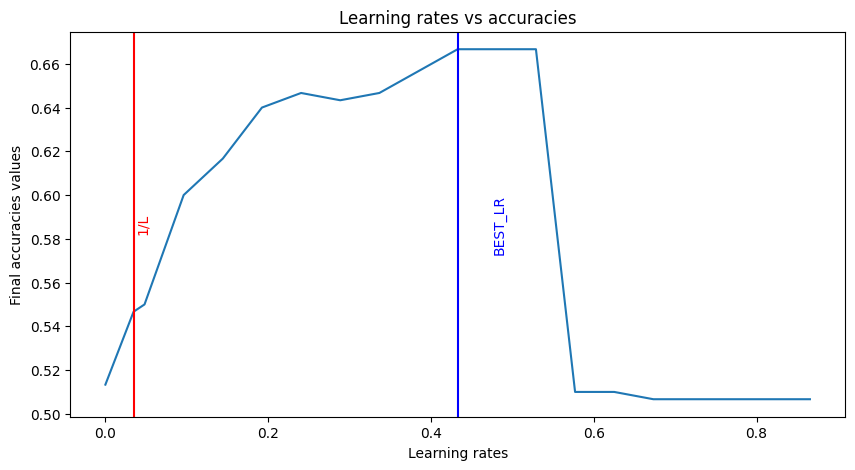

In [42]:
# Final plot for showing the accuracy trend for different learning rates

plt.figure(figsize = (10, 5))
plt.plot(final_accuracies["learning_rates"], final_accuracies["final_accuracies"])

# Line to show the position of 1/L
LC_x = max_alpha * 1.1
LC_y = (final_accuracies["final_accuracies"].max() + final_accuracies["final_accuracies"].min()) / 2
plt.axvline(x=max_alpha, color = 'r')
plt.text(LC_x, LC_y, '1/L', rotation=90, verticalalignment='center', color='red')

# Line to show the position of the best learning rate found by the search performed
BLR_x = best_learning_rate * 1.1
BLR_y = LC_y
plt.axvline(x=best_learning_rate, color = 'b')
plt.text(best_learning_rate * 1.1, (final_accuracies["final_accuracies"].max() + final_accuracies["final_accuracies"].min()) / 2, 'BEST_LR', rotation=90, verticalalignment='center', color='blue')

plt.xlabel("Learning rates")
plt.ylabel("Final accuracies values")
plt.title("Learning rates vs accuracies")
plt.show()

In [43]:
# Best results printing
print("Best results\n")
print("Best accuracy: {}".format(best_accuracy))
print("Best learning rate: {}".format(best_learning_rate))

final_results["toy"]["GS-BCGD"] = {"Best accuracy" : best_accuracy, "1/L accuracy" : results[1/L]['accuracies'][-1]}

Best results

Best accuracy: 0.6667
Best learning rate: 0.4327843928630345


# Final results

In [44]:
def autolabel(bars, ax):
  """This function adds a text label above each bar in a barplot"""
  for bar in bars:
    height = bar.get_height()
    ax.annotate('{:.4f}'.format(height),
                xy = (bar.get_x() + bar.get_width() / 2, height),
                xytext = (0, 3),  # 3 points vertical offset
                textcoords = "offset points",
                ha = 'center', va = 'bottom')

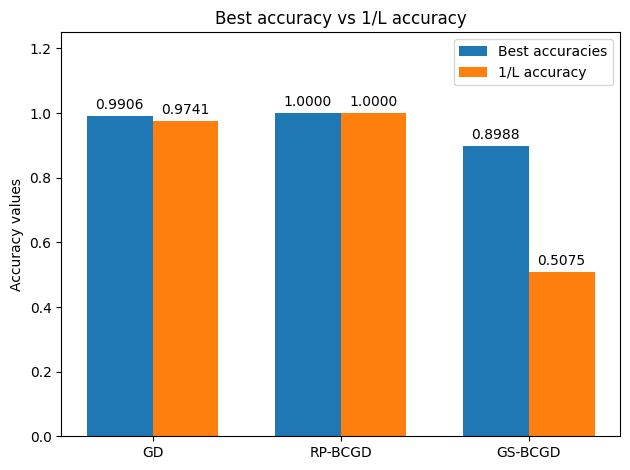

In [45]:
dataset = "synthetic"

categories = list(final_results[dataset].keys())

best_accs = [values["Best accuracy"] for key, values in final_results[dataset].items()]
lipschitz_accs = [values["1/L accuracy"] for key, values in final_results[dataset].items()]

# Indices for the x-axis 
x = np.arange(len(categories))

# Bar width
width = 0.35

fig, ax = plt.subplots()

# Create bars for the two series
bars_1 = ax.bar(x - width/2, best_accs, width, label = "Best accuracies")
bars_2 = ax.bar(x + width/2, lipschitz_accs, width, label = "1/L accuracy")

# Add labels, title and legend
ax.set_ylabel('Accuracy values')
ax.set_title('Best accuracy vs 1/L accuracy')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylim([0, 1.25])
ax.legend()

# These loops add the values on top of each bar
for bars in [bars_1, bars_2]:
  for bar in bars:
    height = bar.get_height()
    ax.annotate('{:.4f}'.format(height),
                xy = (bar.get_x() + bar.get_width() / 2, height),
                xytext = (0, 3),  # 3 points vertical offset
                textcoords = "offset points",
                ha = 'center', va = 'bottom')

fig.tight_layout()

plt.show()

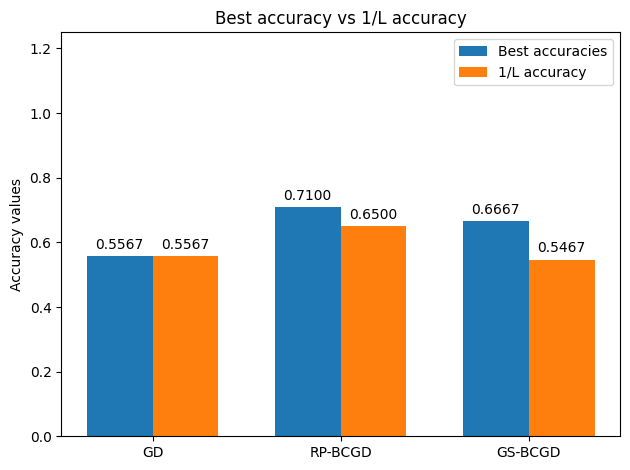

In [46]:
dataset = "toy"

categories = list(final_results[dataset].keys())

best_accs = [values["Best accuracy"] for key, values in final_results[dataset].items()]
lipschitz_accs = [values["1/L accuracy"] for key, values in final_results[dataset].items()]

# Indices for the x-axis 
x = np.arange(len(categories))

# Bar width
width = 0.35

fig, ax = plt.subplots()

# Create bars for the two series
bars_1 = ax.bar(x - width/2, best_accs, width, label = "Best accuracies")
bars_2 = ax.bar(x + width/2, lipschitz_accs, width, label = "1/L accuracy")

# Add labels, title, and legend
ax.set_ylabel('Accuracy values')
ax.set_title('Best accuracy vs 1/L accuracy')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylim([0, 1.25])
ax.legend()

# These loops add the values on top of each bar
for bars in [bars_1, bars_2]:
  for bar in bars:
    height = bar.get_height()
    ax.annotate('{:.4f}'.format(height),
                xy = (bar.get_x() + bar.get_width() / 2, height),
                xytext = (0, 3),  # 3 points vertical offset
                textcoords = "offset points",
                ha = 'center', va = 'bottom')

fig.tight_layout()

plt.show()